<a href="https://colab.research.google.com/github/sasitharanDSAI/project/blob/main/Customer_Churn_Analysis_for_Telecom_Industry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.89      0.86      1033
           1       0.62      0.48      0.54       374

    accuracy                           0.78      1407
   macro avg       0.72      0.69      0.70      1407
weighted avg       0.77      0.78      0.77      1407



100%|===================| 2809/2814 [03:05<00:00]       

SHAP values shape: (1407, 19, 2)
X_test shape: (1407, 19)


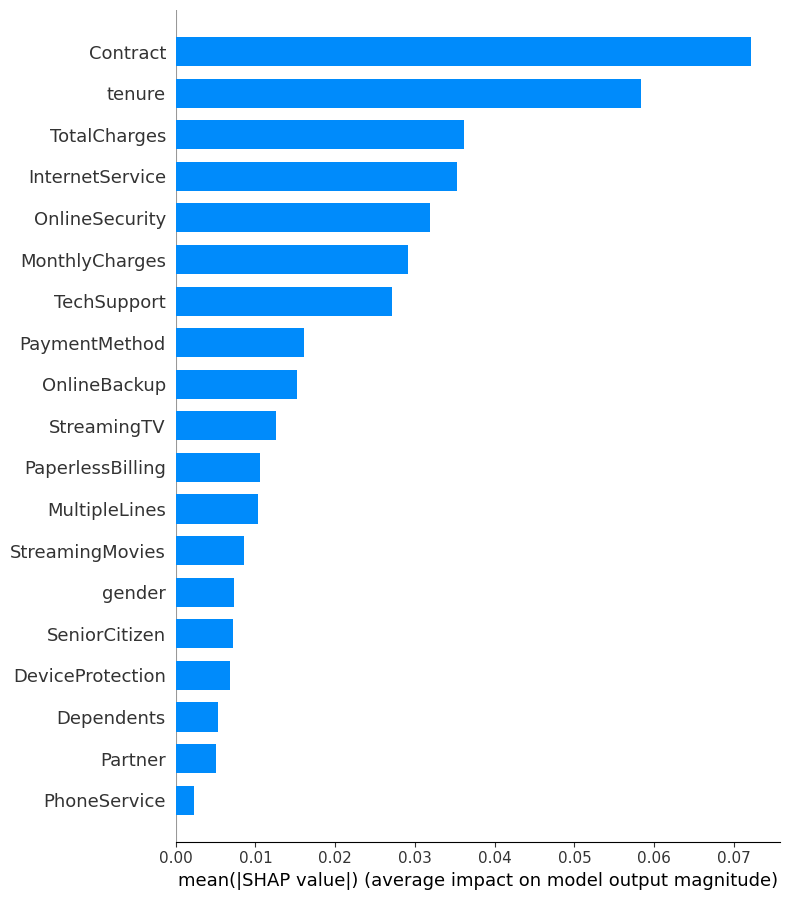

   customerID  churn_prob  segment
0  7590-VHVEG        0.20  Dormant
1  5575-GNVDE        0.01    Loyal
2  3668-QPYBK        0.80  At Risk
3  7795-CFOCW        0.00    Loyal
4  9237-HQITU        0.76  At Risk


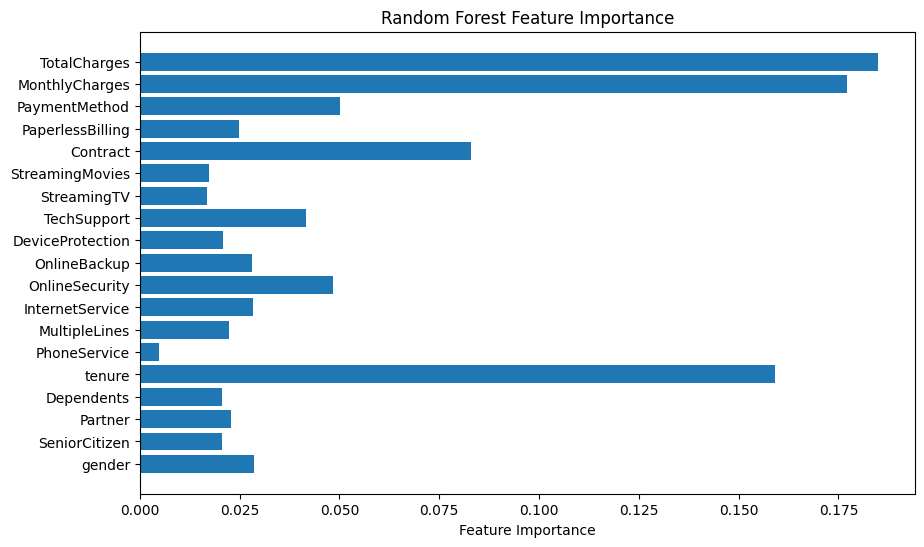

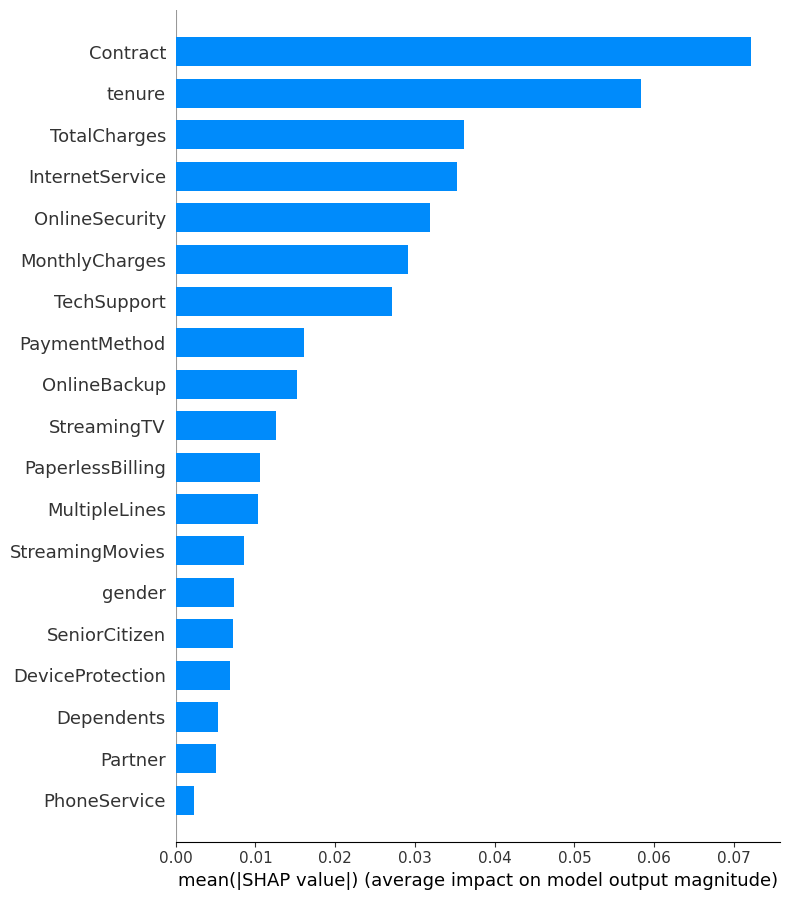

In [2]:
# Required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

# 1. Load and clean the data
df = pd.read_csv('Telco-Customer-Churn.csv')

# Clean TotalCharges column
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.dropna(inplace=True)
df['Churn'] = df['Churn'].map({'No': 0, 'Yes': 1})

# 2. Encode categorical variables
categorical_cols = df.select_dtypes(include='object').columns.tolist()
categorical_cols.remove('customerID')  # exclude ID

# Apply Label Encoding
le = LabelEncoder()
for col in categorical_cols:
    df[col] = le.fit_transform(df[col])

# 3. Define features and target
X = df.drop(columns=['customerID', 'Churn'])
y = df['Churn']

# 4. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 5. Train Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]
print("Classification Report:\n", classification_report(y_test, y_pred))

# 6. SHAP Explainability (Final working code)
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test, check_additivity=False)

# Check SHAP values shape
print("SHAP values shape:", shap_values.values.shape)  # (1407, 19, 2)
print("X_test shape:", X_test.shape)

# Extract SHAP values for class 1 (churn)
shap_values_class1 = shap_values.values[:, :, 1]  # Class 1 SHAP values

# Confirm shapes match
assert shap_values_class1.shape == X_test.shape, "SHAP class 1 and X_test shape mismatch!"

# Summary plot for class 1
shap.summary_plot(shap_values_class1, X_test, plot_type='bar')

# 7. Segment assignment for business use
df['churn_prob'] = model.predict_proba(X)[:, 1]

def segment(row):
    if row['churn_prob'] > 0.6:
        return 'At Risk'
    elif row['tenure'] > 24 and row['Churn'] == 0:
        return 'Loyal'
    elif row['MonthlyCharges'] < 40:
        return 'Dormant'
    else:
        return 'General'

df['segment'] = df.apply(segment, axis=1)

# Show first 5 customers with segment
print(df[['customerID', 'churn_prob', 'segment']].head())

importances = model.feature_importances_
features = X.columns
plt.figure(figsize=(10, 6))
plt.barh(features, importances)
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importance")
plt.show()

shap.summary_plot(shap_values_class1, X_test, plot_type='bar', show=False)
plt.savefig("shap_summary_plot.png", bbox_inches='tight')

df.to_csv("churn_segments.csv", index=False)

